In [162]:
import os

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib import image as mpimg

import seaborn as sns

from sklearn import model_selection
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

from PIL import Image

import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torchvision import transforms

from collections import Counter

from imblearn.over_sampling import RandomOverSampler

import pickle

In [129]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [130]:
#Ucitavanje poadataka i uzimamo manji skup
data = pd.read_csv('kaggle/input/artemis-full/artemis.csv')
data = data[:1000]

In [131]:
data.head()

Unnamed: 0           art_style  \
0           0  Post_Impressionism   
1           1  Post_Impressionism   
2           2  Post_Impressionism   
3           3  Post_Impressionism   
4           4  Post_Impressionism   

                                            painting         emotion  \
0  vincent-van-gogh_portrait-of-madame-ginoux-l-a...  something else   
1  vincent-van-gogh_portrait-of-madame-ginoux-l-a...         sadness   
2  vincent-van-gogh_portrait-of-madame-ginoux-l-a...  something else   
3  vincent-van-gogh_portrait-of-madame-ginoux-l-a...     contentment   
4  vincent-van-gogh_portrait-of-madame-ginoux-l-a...             awe   

                                           utterance  repetition  \
0  She seems very happy in the picture, and you w...          10   
1  This woman has really knotty hands which makes...          10   
2  When looking at this woman, I am filled with c...          10   
3  A woman looking at ease, peaceful, and satisfi...          10   
4  She looks like a lady from that past that migh...          10   

                                                path  
0  /kaggle/input/wikiart/Post_Impressionism/vince...  
1  /kaggle/input/wikiart/Post_Impressionism/vince...  
2  /kaggle/input/wikiart/Post_Impressionism/vince...  
3  /kaggle/input/wikiart/Post_Impressionism/vince...  
4  /kaggle/input/wikiart/Post_Impressionism/vince...

In [135]:
data.shape

(1000, 7)

In [136]:
#Manjem outanju do fajla
correct_path_prefix = 'kaggle/input/wikiart/'
def update_path(path):
    return path.replace('/kaggle/input/wikiart/', correct_path_prefix)

data['path'] = data['path'].apply(update_path)

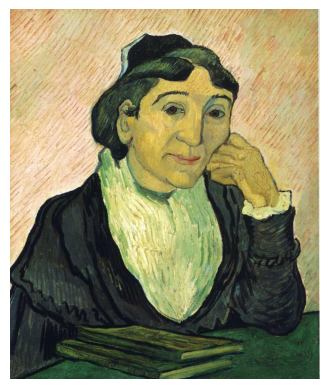

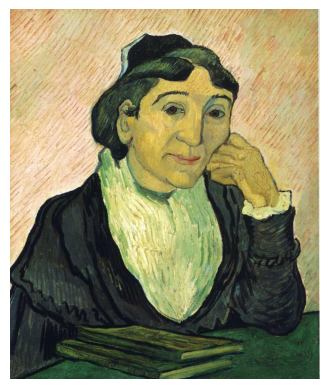

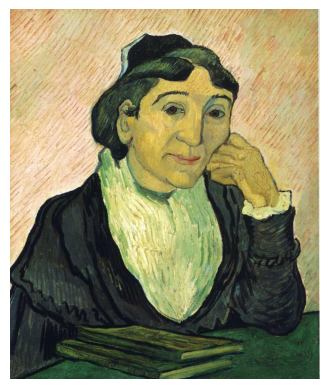

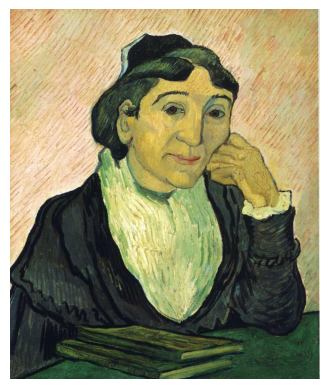

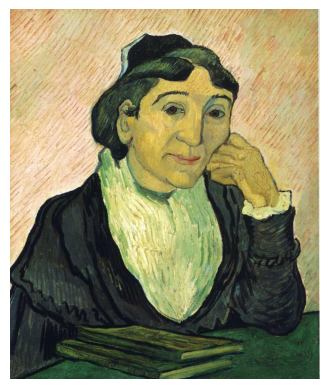

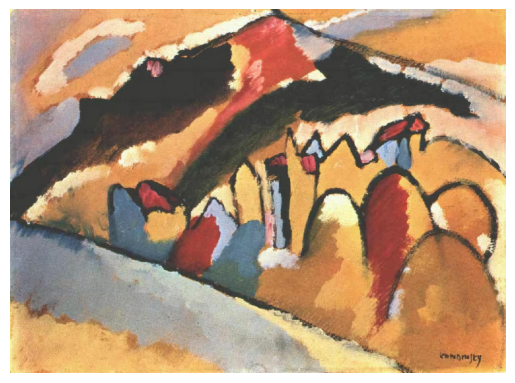

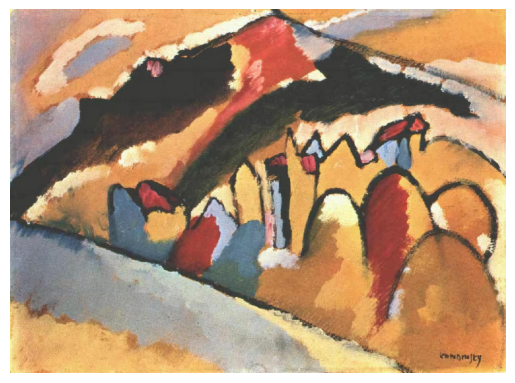

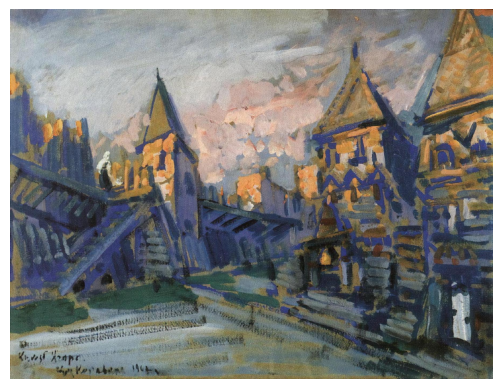

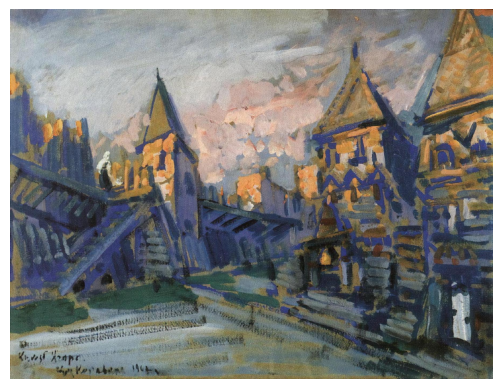

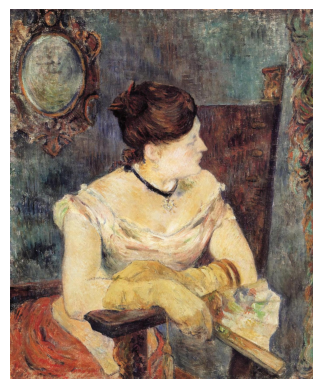

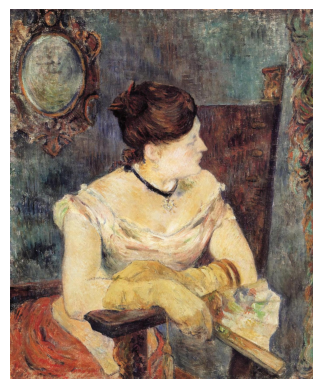

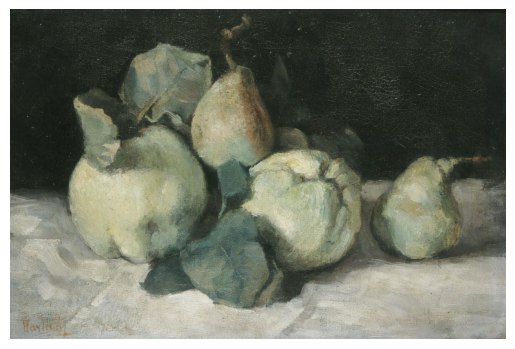

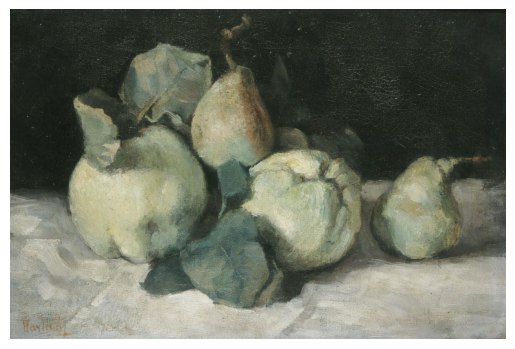

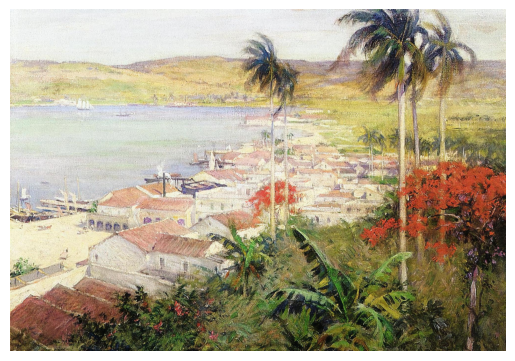

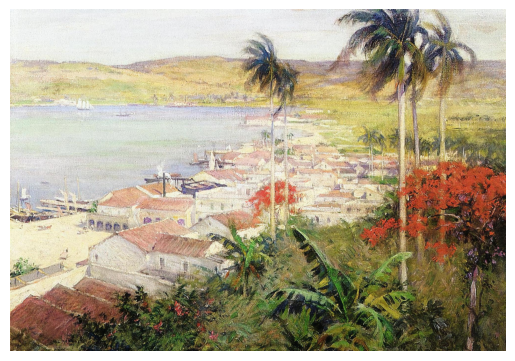

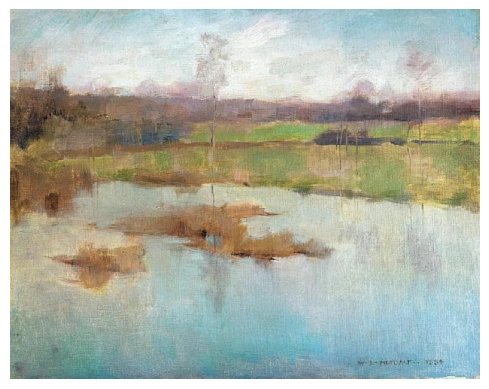

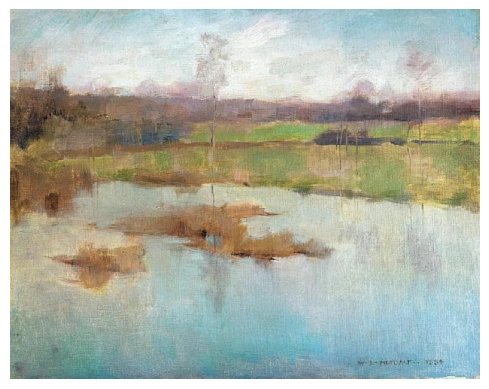

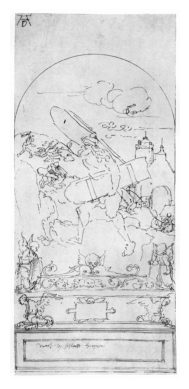

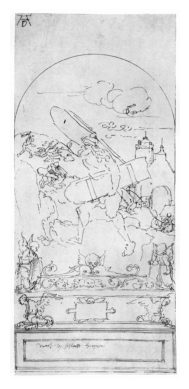

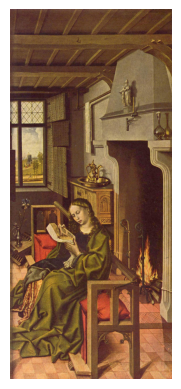

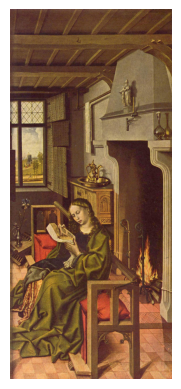

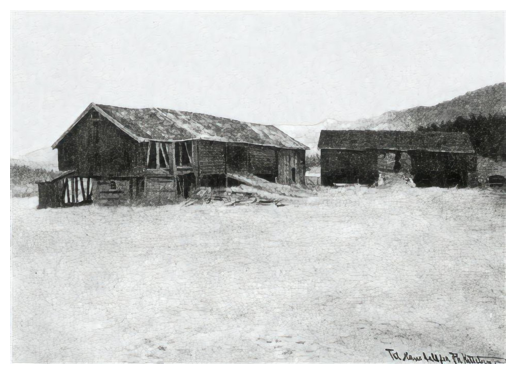

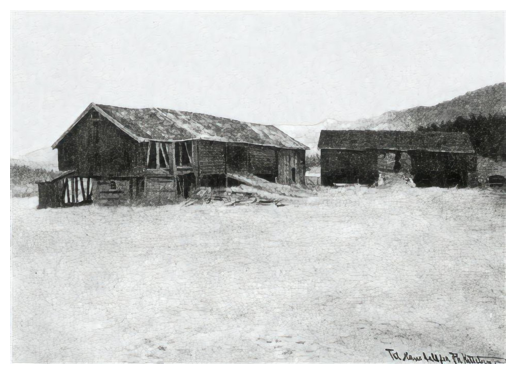

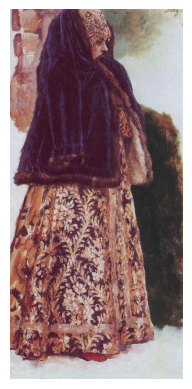

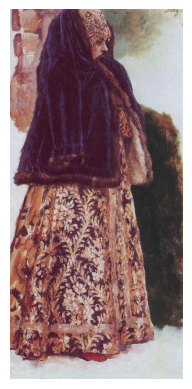

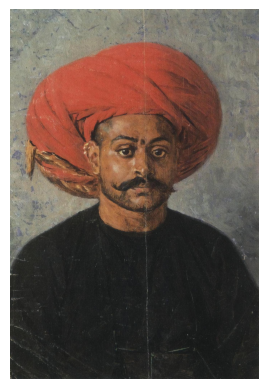

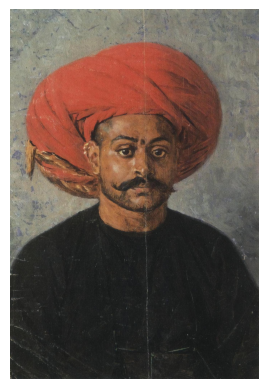

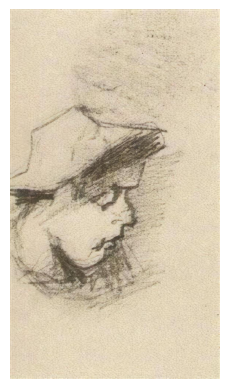

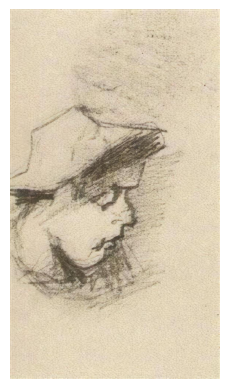

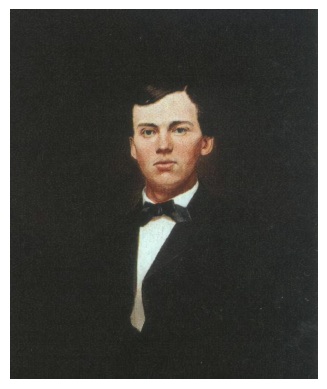

In [139]:
# Uzimamo prvih par redova iz DataFrame-a
sample_paths = data['path'].head(30)
#Iteriramo kroz putanje i prikazujemo slike
for path in sample_paths:
    try:
        img = mpimg.imread(path)
        imgplot = plt.imshow(img)
        plt.axis('off')  # Uklanja ose oko slike
        plt.show()
    except FileNotFoundError:
        print(f"Slika nije pronađena na putanji: {path}")

In [109]:
#ISTRAZIVANJE PODATALA

In [140]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  1000 non-null   int64 
 1   art_style   1000 non-null   object
 2   painting    1000 non-null   object
 3   emotion     1000 non-null   object
 4   utterance   1000 non-null   object
 5   repetition  1000 non-null   int64 
 6   path        1000 non-null   object
dtypes: int64(2), object(5)
memory usage: 54.8+ KB


In [141]:
#emocije su najzastupljenije.
data['emotion'].value_counts()

emotion
contentment       328
awe               218
sadness           117
amusement         109
fear               92
excitement         62
disgust            37
something else     31
anger               6
Name: count, dtype: int64

In [142]:
# Ovde zakljucujemo značajna neravnoteža u distribuciji emocija, gde su emocije poput Contentment i 
#Awe mnogo češće zastupljene nego emocije poput Disgust i Anger.

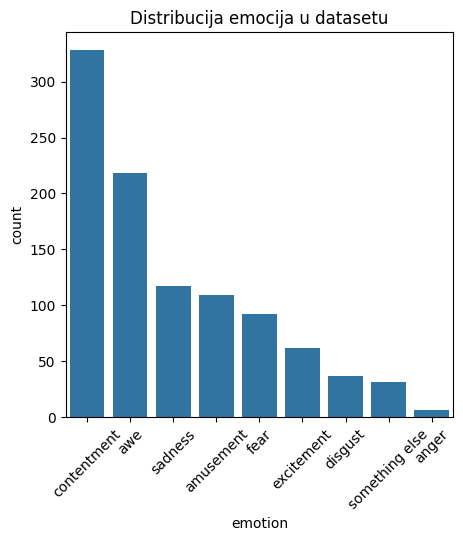

In [143]:
plt.figure(figsize=(5,5))
sns.countplot(x='emotion', data=data, order=data['emotion'].value_counts().index)
plt.title('Distribucija emocija u datasetu')
plt.xticks(rotation=45)
plt.show()

In [144]:
#Podela podataka 

In [145]:
#Prebacujemo emocije u  numericke vrednosti
image_paths = data['path'].values
emotions = data['emotion'].values
# Pretvaranje emocija u numeričke vrednosti
label_encoder = preprocessing.LabelEncoder()
emotions_encoded = label_encoder.fit_transform(emotions)


In [146]:

# Definisanje transformacija za slike (promena veličine i normalizacija)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Promena veličine slika
    transforms.ToTensor(),  # Pretvaranje slike u tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalizacija prema ImageNet standardu
])


In [147]:
X = image_paths.reshape(-1, 1)  # Pretvaranje u 2D niz jer RandomOverSampler očekuje 2D podatke
y = emotions_encoded

# Oversampling koristeći RandomOverSampler, jer su podaci neravnomerno rasporedjenipo klasama
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

# Vraćanje X_resampled u originalni oblik
image_paths_resampled = X_resampled.flatten()

# Proverimo nove veličine nakon oversamplinga
print(f"Originalna veličina: {len(image_paths)}")
print(f"Veličina nakon oversamplinga: {len(image_paths_resampled)}")

# Ako želite podeliti resamplovane podatke na trening i validacioni set:
image_paths_train, image_paths_temp, y_train, y_temp = model_selection.train_test_split(image_paths_resampled, y_resampled, test_size=0.2, random_state=7)
image_paths_val, image_paths_test, y_val, y_test = model_selection.train_test_split(image_paths_temp, y_temp, test_size=0.5, random_state=7)

# Prikazivanje distribucije klasa nakon oversamplinga
unique, counts = np.unique(y_resampled, return_counts=True)
print(f"Distribucija klasa nakon oversamplinga: {dict(zip(unique, counts))}")

Originalna veličina: 1000
Veličina nakon oversamplinga: 2952
Distribucija klasa nakon oversamplinga: {0: 328, 1: 328, 2: 328, 3: 328, 4: 328, 5: 328, 6: 328, 7: 328, 8: 328}


In [148]:
class ArtDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")  # Load image
        label = torch.zeros(len(label_encoder.classes_))
        label[self.labels[idx]] = 1  # Set the appropriate positions to 1
        
        if self.transform:
            image = self.transform(image)
        
        return image, label


In [149]:
# Kreiranje DataLoader-a za svaki set
train_dataset = ArtDataset(image_paths_train, y_train, transform=transform)
val_dataset = ArtDataset(image_paths_val, y_val, transform=transform)
test_dataset = ArtDataset(image_paths_test, y_test, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)



In [150]:
# Ucia=tavamo ResNet18 model
resnet18 = models.resnet18(pretrained=True)

num_ftrs = resnet18.fc.in_features
resnet18.fc = nn.Linear(num_ftrs, len(label_encoder.classes_))

# Koristimo sigmoidnu funkciju kao aktivacioni=u
model1 = nn.Sequential(
    resnet18,
    nn.Sigmoid()
)

model1 = model1.to(device)

/home/aleksandra/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/aleksandra/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [151]:
# Definisemo optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model1.parameters(), lr=0.00001)


In [26]:
# Inicijalizacija
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

num_epochs = 4

for epoch in range(num_epochs):
    model1.train()
    running_loss = 0.0
    running_corrects = 0
    
    print(f"\nEpoch [{epoch+1}/{num_epochs}]")
    
    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = bind_gpu((images, labels))
        
        optimizer.zero_grad()
        outputs = model1(images)
        
        loss = criterion(outputs, labels.float())  # Convert labels to float for BCEWithLogitsLoss
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

        # Konvertujemo iutput u binarni
        preds = (outputs > 0.5).float()
        running_corrects += (preds == labels).float().mean().item()
        
        # Prikazujemo progres na svakih 10 batch-eva
        if (batch_idx + 1) % 10 == 0:
            print(f"  Batch [{batch_idx+1}/{len(train_loader)}] - Loss: {loss.item():.4f}")

    # Izracunavamo prosecni loss i accuracy
    avg_train_loss = running_loss / len(train_loader)
    avg_train_acc = running_corrects / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accuracies.append(avg_train_acc)

    # Validation
    model1.eval()
    val_loss = 0.0
    val_corrects = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(val_loader):
            images, labels = bind_gpu((images, labels))
            
            outputs = model1(images)
            loss = criterion(outputs, labels.float())
            
            val_loss += loss.item()

            preds = (outputs > 0.5).float()
            val_corrects += (preds == labels).float().mean().item()
            
            all_labels.append(labels.cpu().numpy())
            all_preds.append(preds.cpu().numpy())

    avg_val_loss = val_loss / len(val_loader)
    avg_val_acc = val_corrects / len(val_loader)
    val_losses.append(avg_val_loss)
    val_accuracies.append(avg_val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] completed.")
    print(f"  Average Training Loss: {avg_train_loss:.4f} | Training Accuracy: {avg_train_acc:.4f}")
    print(f"  Average Validation Loss: {avg_val_loss:.4f} | Validation Accuracy: {avg_val_acc:.4f}")

all_labels = np.concatenate(all_labels)
all_preds = np.concatenate(all_preds)



Epoch [1/4]
  Batch [10/74] - Loss: 0.8942
  Batch [20/74] - Loss: 0.8818
  Batch [30/74] - Loss: 0.8790
  Batch [40/74] - Loss: 0.8647
  Batch [50/74] - Loss: 0.8589
  Batch [60/74] - Loss: 0.8498
  Batch [70/74] - Loss: 0.8478
Epoch [1/4] completed.
  Average Training Loss: 0.8686 | Training Accuracy: 0.6897
  Average Validation Loss: 0.8430 | Validation Accuracy: 0.7849

Epoch [2/4]
  Batch [10/74] - Loss: 0.8342
  Batch [20/74] - Loss: 0.8276
  Batch [30/74] - Loss: 0.8198
  Batch [40/74] - Loss: 0.8112
  Batch [50/74] - Loss: 0.8054
  Batch [60/74] - Loss: 0.8020
  Batch [70/74] - Loss: 0.7997
Epoch [2/4] completed.
  Average Training Loss: 0.8181 | Training Accuracy: 0.8437
  Average Validation Loss: 0.8003 | Validation Accuracy: 0.8828

Epoch [3/4]
  Batch [10/74] - Loss: 0.7971
  Batch [20/74] - Loss: 0.7938
  Batch [30/74] - Loss: 0.7820
  Batch [40/74] - Loss: 0.7782
  Batch [50/74] - Loss: 0.7793
  Batch [60/74] - Loss: 0.7866
  Batch [70/74] - Loss: 0.7659
Epoch [3/4] comp

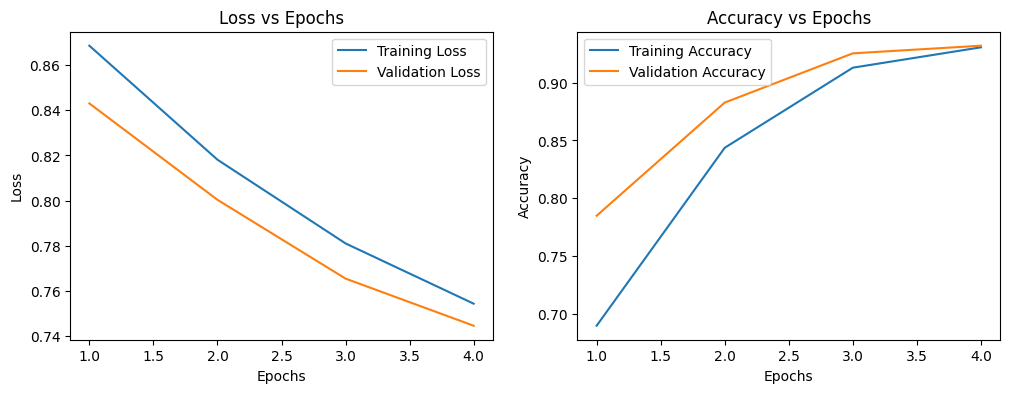

In [27]:
# Plot loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')
plt.legend()

plt.show()


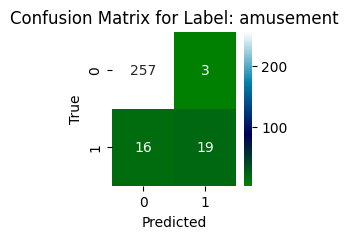

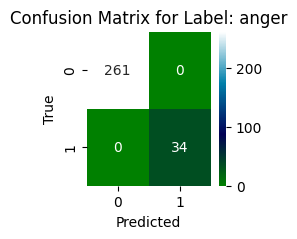

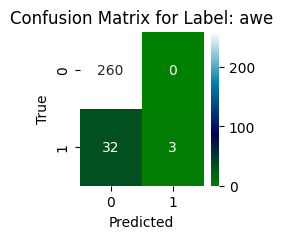

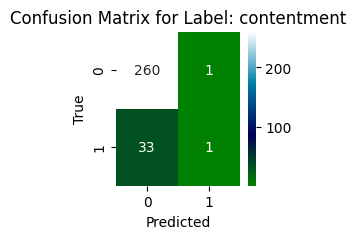

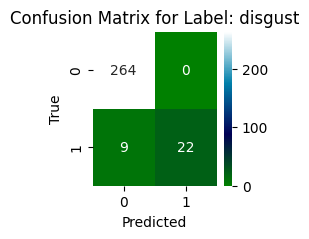

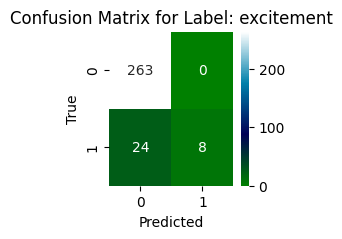

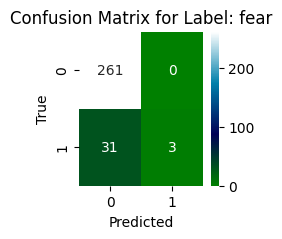

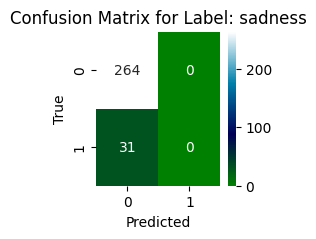

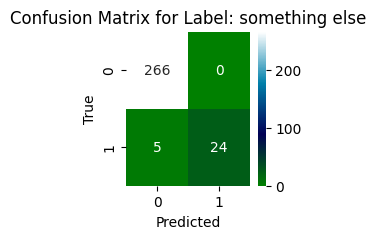

In [28]:
# Ispisujemo matrice jonfuzije po klasama
conf_matrix = multilabel_confusion_matrix(all_labels, all_preds)

# Plot the confusion matrix for each label
for i, matrix in enumerate(conf_matrix):
    plt.figure(figsize=(2, 2))
    sns.heatmap(matrix, annot=True, fmt='d', cmap='ocean')
    plt.title(f'Confusion Matrix for Label: {label_encoder.classes_[i]}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()


In [29]:

for inputs, labels in train_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model1(inputs)
    print(outputs)
    break  # Check the output for one batch and exit

predicted = (outputs > 0.3).float()
for inputs, labels in train_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model1(inputs)
    
    print("Model Outputs: ", outputs)
    print("Predicted Labels (before threshold): ", outputs)
    
    predicted = (outputs > 0.5).float()
    print("Predicted Labels (after threshold): ", predicted)
    
    print("True Labels: ", labels)
    break  # Check for one batch

tensor([[0.2517, 0.0807, 0.2476, 0.3132, 0.1146, 0.2264, 0.1276, 0.1536, 0.1341],
        [0.4920, 0.0478, 0.3300, 0.2764, 0.1044, 0.1376, 0.0944, 0.1117, 0.1131],
        [0.1856, 0.1284, 0.6739, 0.2308, 0.1322, 0.1073, 0.0788, 0.1498, 0.2771],
        [0.2624, 0.0525, 0.2705, 0.2335, 0.0958, 0.4301, 0.1155, 0.1154, 0.2870],
        [0.2900, 0.0545, 0.3172, 0.4252, 0.1650, 0.1610, 0.1223, 0.1162, 0.1350],
        [0.2476, 0.0512, 0.2156, 0.2730, 0.2350, 0.1502, 0.0961, 0.1637, 0.1471],
        [0.3103, 0.0525, 0.4449, 0.3279, 0.1999, 0.1189, 0.0921, 0.1802, 0.2713],
        [0.3546, 0.0486, 0.3987, 0.2459, 0.1678, 0.2045, 0.0586, 0.1123, 0.3427],
        [0.1665, 0.0511, 0.1608, 0.1305, 0.0659, 0.0838, 0.0582, 0.0913, 0.9658],
        [0.2361, 0.0522, 0.4165, 0.2390, 0.1236, 0.0963, 0.0741, 0.1064, 0.2039],
        [0.2067, 0.0525, 0.1938, 0.1979, 0.1418, 0.3871, 0.1594, 0.1618, 0.1827],
        [0.2434, 0.0695, 0.1947, 0.2465, 0.1348, 0.1424, 0.0489, 0.2904, 0.1042],
        [0.2000,

In [ ]:
# Izgradnja osnovnog CNN modela u PyTorch-u

In [152]:
def evaluate_multilabel_classification_per_class(model, criterion, loader):
    model.eval()
    total_loss = 0.0
    total_samples = 0
    predicted_labels, true_labels = [], []

    with torch.no_grad():  # No gradient computation during evaluation
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels.float())  # Compute the loss

            total_loss += loss.item()

            # Apply sigmoid and threshold for multi-label classification
            predicted = (outputs > 0.5).float()

            predicted_labels.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

            total_samples += labels.size(0)

    # Convert to numpy arrays for metric calculation
    predicted_labels = np.array(predicted_labels)
    true_labels = np.array(true_labels)

    # Calculate metrics
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision, recall, f1_score, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='weighted')
    print(f'Model evaluation:')
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1_score:.4f}")

    # Plot confusion matrices for each label
    num_classes = true_labels.shape[1]
    for i in range(num_classes):
        cm = confusion_matrix(true_labels[:, i], predicted_labels[:, i])
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix for Class {i} - {label_encoder.classes_[i]}')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

    avg_loss = total_loss / len(loader)
    return avg_loss, accuracy

# Example usage:
# test_loss, test_accuracy = evaluate_multilabel_classification_per_class(model1, criterion, test_loader)


Model evaluation:
Accuracy: 0.0000
Precision: 0.0823
Recall: 0.3953
F1 Score: 0.1191


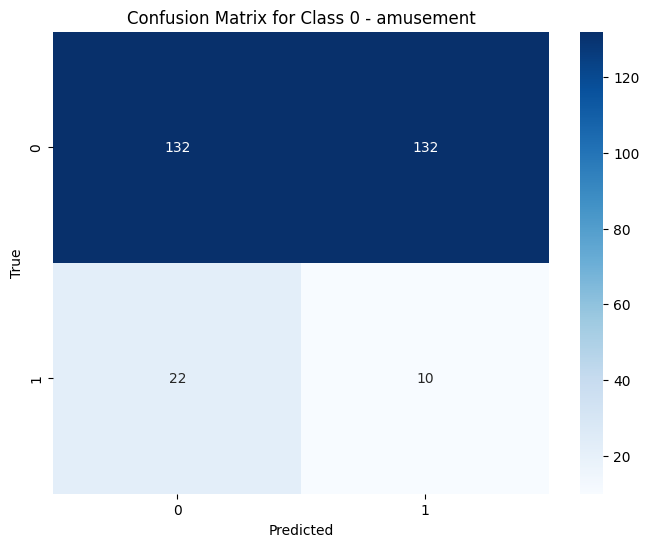

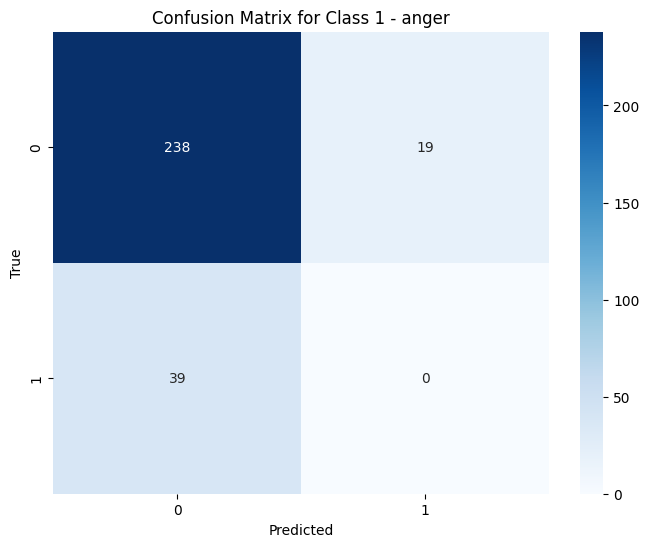

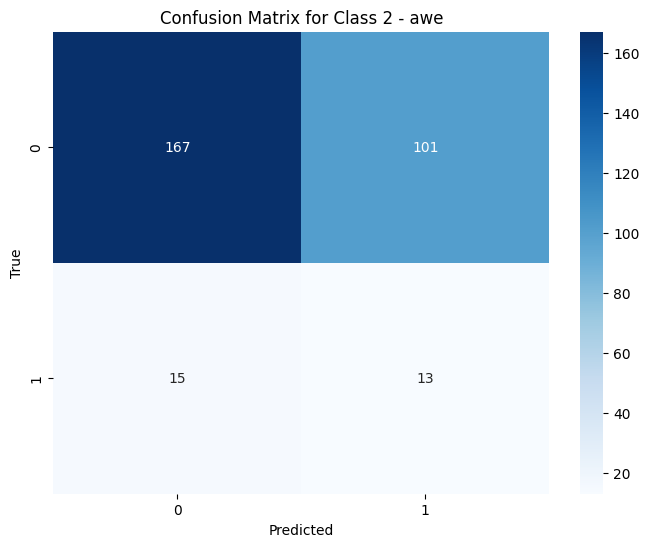

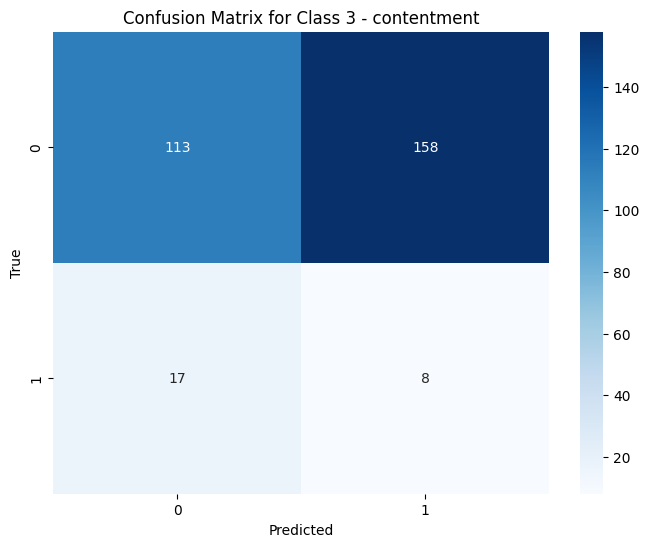

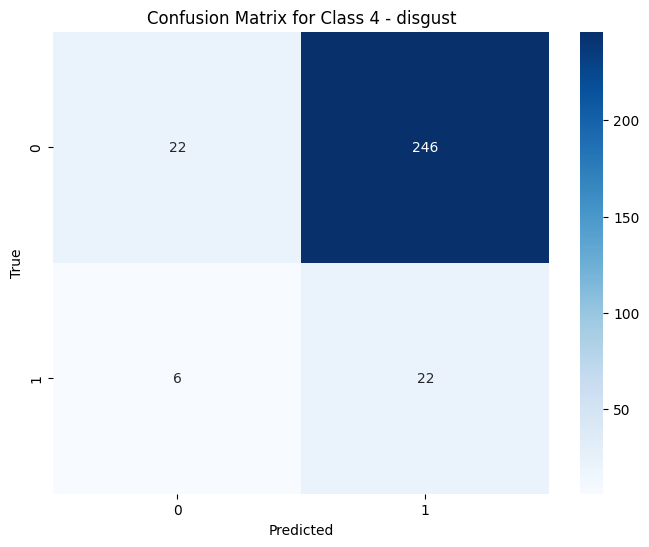

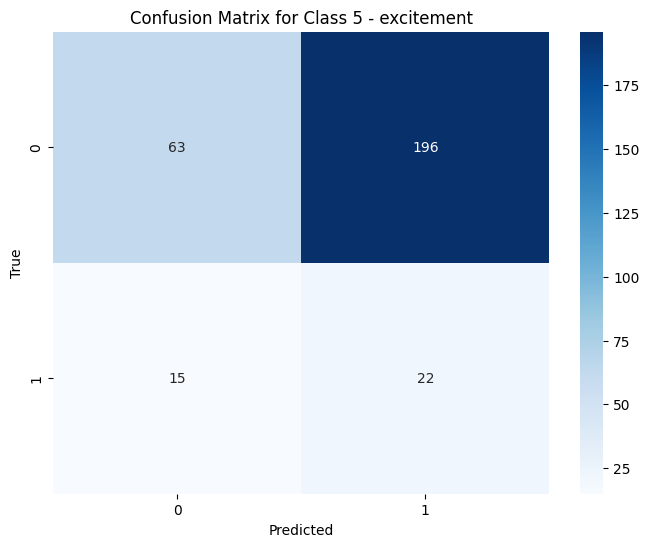

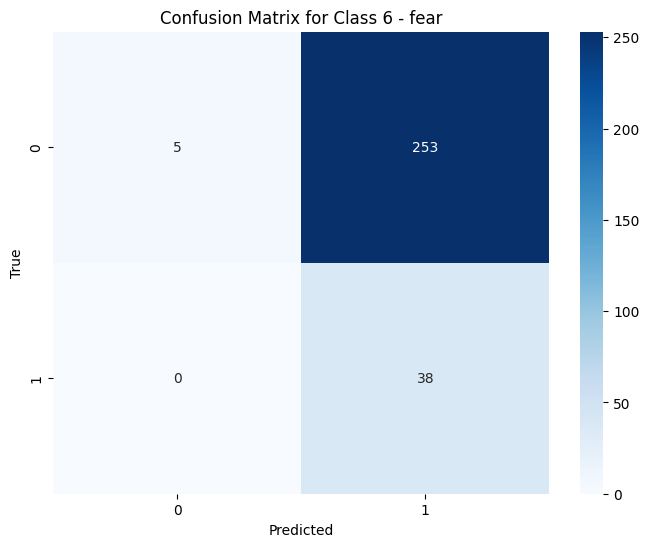

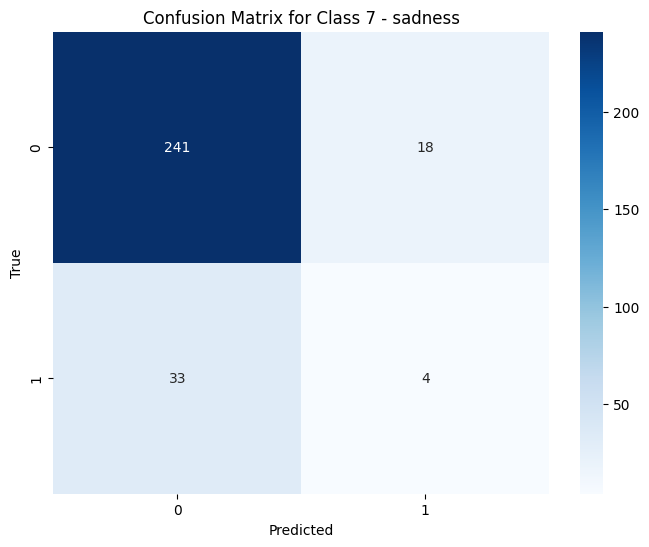

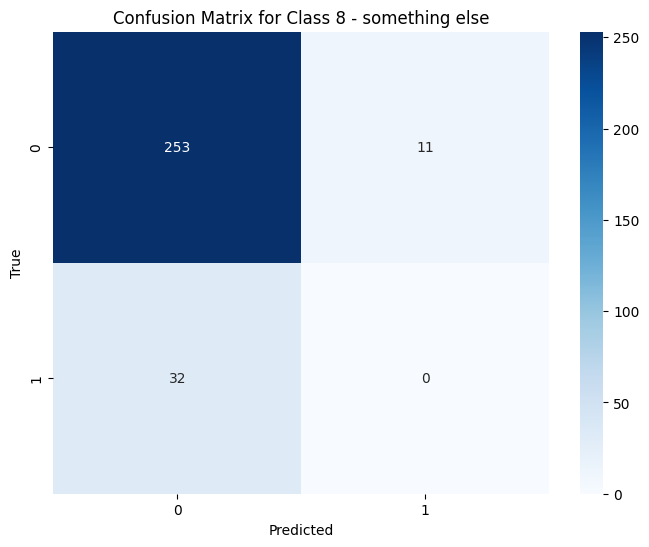

In [153]:
test_loss, test_accuracy = evaluate_multilabel_classification_per_class(model1, criterion, test_loader)


In [123]:
#Drugi model koji koristimo je AlexNet
def create_alexnet_model(num_classes):
    model = models.alexnet(pretrained=True)
    model.classifier[6] = nn.Linear(in_features=4096, out_features=num_classes)
    return model

# Inicijalizacija modela sa brojem klasa
num_classes = len(label_encoder.classes_)
model = create_alexnet_model(num_classes)

In [156]:
def train_model(model, train_loader, valid_loader, num_epochs, learning_rate=0.0001):
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = StepLR(optimizer, step_size=5, gamma=0.1)  # Decays the learning rate by a factor of 0.1 every 5 epochs

    best_accuracy = 0.0
    train_losses = []
    valid_accuracies = []

    
    for epoch in range(num_epochs):
        # Trening modela
        model.train()
        running_loss = 0.0
        
        print(f"\nEpoch [{epoch+1}/{num_epochs}]")
        
        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            
            # Konverzija one-hot kodiranih oznaka u indekse klasa
            if labels.dim() > 1:
                labels = torch.argmax(labels, dim=1)
            
            optimizer.zero_grad()
            outputs = model(images)
            
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()* images.size(0)
            
            _, predicted = torch.max(outputs.data, 1)
            
        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

        model.eval()
        valid_labels = []
        valid_preds = []
        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                if labels.dim() > 1:
                    labels = torch.argmax(labels, dim=1)
                    outputs = model(images)
                    _, preds = torch.max(outputs, 1)
                    valid_labels.extend(labels.cpu().numpy())
                    valid_preds.extend(preds.cpu().numpy())
        accuracy = accuracy_score(valid_labels, valid_preds)
        valid_accuracies.append(accuracy)
        print(f"Validation Accuracy: {accuracy * 100:.2f}%")

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            torch.save(model.state_dict(), 'best_model.pth')

        scheduler.step()

    return train_losses, valid_accuracies


In [157]:
# Inicijalizacija modela sa brojem klasa
num_classes = len(label_encoder.classes_)
model = create_alexnet_model(num_classes)

# Prebacivanje modela na GPU
model = model.to(device)

# Definisanje kriterijuma i optimizatora
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Treniranje modela sa detaljnim ispisima
num_epochs = 10
train_losses, valid_accuracies = train_model(model, train_loader, val_loader, num_epochs)


Epoch [1/10]
Epoch 1/10, Loss: 1.4007
Validation Accuracy: 76.27%

Epoch [2/10]
Epoch 2/10, Loss: 0.4778
Validation Accuracy: 85.08%

Epoch [3/10]
Epoch 3/10, Loss: 0.2142
Validation Accuracy: 85.08%

Epoch [4/10]
Epoch 4/10, Loss: 0.1309
Validation Accuracy: 87.12%

Epoch [5/10]
Epoch 5/10, Loss: 0.0770
Validation Accuracy: 86.10%

Epoch [6/10]
Epoch 6/10, Loss: 0.0499
Validation Accuracy: 85.76%

Epoch [7/10]
Epoch 7/10, Loss: 0.0395
Validation Accuracy: 86.10%

Epoch [8/10]
Epoch 8/10, Loss: 0.0371
Validation Accuracy: 85.08%

Epoch [9/10]
Epoch 9/10, Loss: 0.0360
Validation Accuracy: 86.44%

Epoch [10/10]
Epoch 10/10, Loss: 0.0295
Validation Accuracy: 86.78%


In [161]:
'''
Vidimo da je gubitak drastično opao od prve epohe (1.4007) do poslednje (0.0295). 
To ukazuje na to da se model postepeno poboljšava i da bolje uči karakteristike iz podataka.
U kasnijim epohama, gubitak se stabilizuje i smanjuje mnogo sporije,
što je znak da se model bliži svojoj optimalnoj tački ili da može biti blizu prenaučavanja.

Model pokazuje dobar progres tokom treniranja, sa gubitkom koji značajno opada i tačnošću koja postepeno raste, 
što ukazuje na uspešno učenje.
'''

'\nVidimo da je gubitak drastično opao od prve epohe (1.4007) do poslednje (0.0295). \nTo ukazuje na to da se model postepeno poboljšava i da bolje uči karakteristike iz podataka.\nU kasnijim epohama, gubitak se stabilizuje i smanjuje mnogo sporije,\nšto je znak da se model bliži svojoj optimalnoj tački ili da može biti blizu prenaučavanja.\n\nModel pokazuje dobar progres tokom treniranja, sa gubitkom koji značajno opada i tačnošću koja postepeno raste, \nšto ukazuje na uspešno učenje.\n'

In [158]:
def plot_results(train_losses, valid_accuracies):
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(valid_accuracies) + 1), [acc * 100 for acc in valid_accuracies], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Validation Accuracy')
    plt.legend()
    
    plt.show()

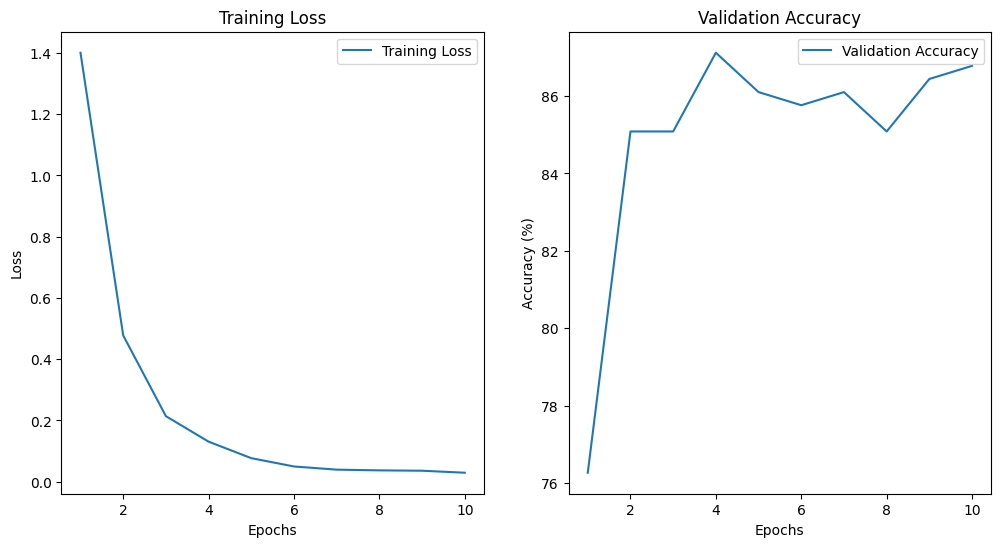

In [159]:
plot_results(train_losses, valid_accuracies)

In [165]:
"""Cuvanje podataka"""
model_filename = 'models/resnet18.model'

with open(model_filename, 'wb') as pickle_file:
    pickle.dump(model1, pickle_file)

model_filename = 'models/alex.model'

with open(model_filename, 'wb') as pickle_file:
    pickle.dump(model, pickle_file)